In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from typing import Optional, List
import matplotlib.pyplot as plt

In [2]:
num_batch, num_token, dim = 1, 10, 32
num_heads=2
window=2
x = torch.randn(num_batch,num_token,dim)
head_dim = dim // num_heads
kernel_size = 2*window + 1

# token 0 を global token にする例
global_mask = torch.zeros(num_batch,num_token, dtype=torch.bool)
global_mask[0,0] = True

In [3]:
# ネットワークパラメータ定義
q_proj = nn.Linear(dim, dim)
k_proj = nn.Linear(dim, dim)
v_proj = nn.Linear(dim, dim)
out_proj = nn.Linear(dim, dim)

In [4]:
# Q,K,Vの計算
q = q_proj(x).view(num_batch, num_token, num_heads, head_dim).transpose(1,2)
k = k_proj(x).view(num_batch, num_token, num_heads, head_dim).transpose(1,2)
v = v_proj(x).view(num_batch, num_token, num_heads, head_dim).transpose(1,2)

q.shape

torch.Size([1, 2, 10, 16])

local score map


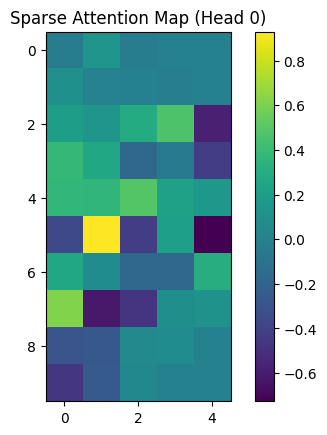

In [5]:
# Local scoreの計算
local_scores = torch.zeros(num_batch,num_heads,num_token,kernel_size, device=x.device)

for t in range(num_token):
  L = max(0, t-window)
  R = min(num_token, t+window+1)
  k_local = k[:,:,L:R,:]
  q_t = q[:,:,t:t+1,:]
  score = torch.einsum("bhid,bhjd->bhij", q_t, k_local) / (head_dim**0.5)
  local_scores[:,:,t,:R-L] = score.squeeze(2)

print("local score map")
# 可視化（head 0）
plt.imshow(local_scores[0,0].detach().cpu(), cmap="viridis")
plt.colorbar()
plt.title("Sparse Attention Map (Head 0)")
plt.show()


# 特別なトークン

Sparse Attention では "特別なトークン" にだけ Global Attention を行う

例えば：

[CLS] トークン

質問応答の "質問側" トークン

セパレータトークン

重要な文に手動で指定された token

前提

q: (B, H, T, D)

k: (B, H, T, D)

global_mask[b]: (T,): True の位置がグローバルトークン位置

計算後の形
変数	形状	意味
idx	(G,)	global トークン数
k_g	(H, G, D)	global key
score	(H, T, G)	各 Query から Global Key への attention score

In [ ]:
global_mask

tensor([[ True, False, False, False, False, False, False, False, False, False]])

global_maskの先頭がTrueなのは上記の通り先頭→先頭がグローバルトークン

続いて、qと対象となるバッチ、グローバルトークンに基づいた内積を計算する。

**全 Query トークンが Global トークンにどれだけ注意を向けるべきかを計算するための dot-product attention スコアを求める式**

**ヘッド毎に、全トークン×全グローバルトークンの関連度を計算している**

In [6]:
# --------------------------------------------------------------
# Global scores
# --------------------------------------------------------------
global_scores = []
global_idx_list = []

for b in range(num_batch):
    idx = torch.nonzero(global_mask[b], as_tuple=False).squeeze(-1)
    global_idx_list.append(idx)
    if idx.numel() == 0:
        global_scores.append(None)
        continue
    k_g = k[b,:,idx,:]
    score = torch.einsum("htd,hgd->htg", q[b], k_g) / (head_dim**0.5)
    global_scores.append(score)

global_scores[0].shape

torch.Size([2, 10, 1])

In [12]:
L = max(0, t-window)
R = min(num_token, 0+window+1)

local_s = local_scores[0,0,0,:R-L]

# 個々の計算イメージ
g_idx = global_idx_list[0]
g_score = global_scores[0][0,0]   # (G)

print(g_idx)
print(g_score)

tensor([0])
tensor([-0.0297], grad_fn=<SelectBackward0>)


In [15]:
# ローカルとグローバルのスコアから確率化
s = torch.cat([local_s, g_score], dim=-1)
attn = F.softmax(s, dim=-1)

# separate weights
attn_loc = attn[:R-L]
attn_g   = attn[R-L:]

print(attn_loc)
print(attn_g)

tensor([], grad_fn=<SliceBackward0>)
tensor([0.5000, 0.5000], grad_fn=<SliceBackward0>)


In [17]:
L

7

local score map


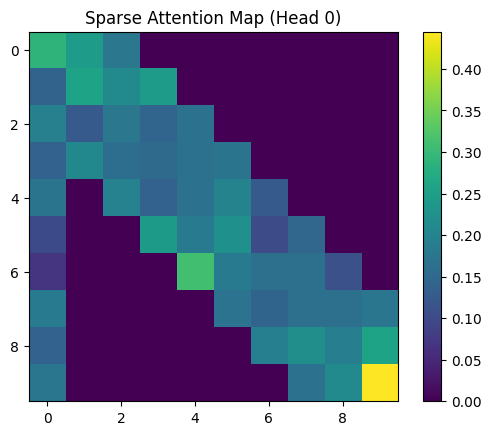

In [ ]:
# --------------------------------------------------------------
# Out: heads
# --------------------------------------------------------------
out_heads = torch.zeros(num_batch,num_heads,num_token,head_dim, device=x.device)
full_attn = torch.zeros(num_batch,num_heads,num_token,num_token, device=x.device)

# バッチごとの計算
for b in range(num_batch):
    # ヘッドごとの計算
    for h in range(num_heads):
        # トークンごとの計算
        for t in range(num_token):

            L = max(0, t-window)
            R = min(num_token, t+window+1)
            local_s = local_scores[b,h,t,:R-L]

            if global_scores[b] is None:
                attn = F.softmax(local_s, dim=-1)
                v_loc = v[b,h,L:R,:]
                ctx = torch.sum(attn.unsqueeze(-1)*v_loc, dim=-2)

                # full attention map
                full_attn[b,h,t,L:R] = attn

            else:
                g_idx = global_idx_list[b]
                g_score = global_scores[b][h,t]   # (G)
                s = torch.cat([local_s, g_score], dim=-1)
                attn = F.softmax(s, dim=-1)

                # separate weights
                attn_loc = attn[:R-L]
                attn_g   = attn[R-L:]

                v_loc = v[b,h,L:R,:]
                v_g   = v[b,h,g_idx,:]

                ctx = (
                    torch.sum(attn_loc.unsqueeze(-1)*v_loc, dim=-2) +
                    torch.sum(attn_g.unsqueeze(-1)*v_g, dim=-2)
                )

                out_heads[b,h,t] = ctx

                # ★ full attention map の構築
                full_attn[b,h,t,L:R] = attn_loc
                full_attn[b,h,t, g_idx] = attn_g


print("local score map")
# 可視化（head 0）
plt.imshow(full_attn[0,0].detach().cpu(), cmap="viridis")
plt.colorbar()
plt.title("Sparse Attention Map (Head 0)")
plt.show()

In [ ]:
num_batch, num_token, dim = 1, 10, 32
num_heads=2
window=2
x = torch.randn(num_batch,num_token,dim)
head_dim = dim // num_heads
kernel_size = 2*window + 1

In [ ]:
# 最終出力は以下

out = out_heads.transpose(1,2).reshape(num_batch,num_token,dim)
out = out_proj(out)

print(out)

tensor([[[-6.9850e-02, -1.9918e-01,  8.6535e-02, -2.7290e-02, -2.8651e-01,
          -5.0557e-01, -2.9784e-01,  8.9496e-02, -1.4948e-01, -9.4318e-02,
          -2.5917e-02, -2.8758e-01,  1.4306e-01, -1.5618e-01, -4.1445e-01,
          -1.4454e-01, -1.8270e-01,  8.6898e-02,  4.8036e-02,  4.8411e-02,
          -1.5367e-01,  3.0513e-01, -2.2914e-01, -4.4115e-02,  2.7482e-01,
          -5.9749e-02, -4.3902e-01,  3.5585e-01, -2.5314e-02, -1.7803e-01,
          -1.2090e-01, -9.9007e-02],
         [-1.0548e-01, -3.3742e-01, -2.2318e-01, -8.1475e-02, -1.7720e-01,
          -5.1110e-01, -3.4668e-01,  1.3376e-01, -3.7139e-03, -3.1896e-01,
          -4.9304e-02, -2.2894e-01,  2.0144e-01,  1.1363e-01, -2.0111e-01,
          -2.0855e-01, -1.6205e-01, -6.8784e-02,  2.4411e-02,  2.4881e-01,
          -9.3432e-02,  2.7954e-01, -9.8567e-02,  2.5792e-02,  3.0612e-01,
           4.0707e-03, -5.3014e-01,  1.0435e-01,  4.5110e-02, -1.1700e-01,
          -3.7213e-02, -2.4939e-01],
         [-1.2764e-01, -2.